# GFDL FLOR Historical

## Loads in all monthly forecasts of sea ice extent
## Regrids to polar stereographic,
## Saves to a netcdf file

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Data dir
data_dir = r'/home/disk/sipn/nicway/data/model/nmme/GFDL_FLORB01/hist/nomads.gfdl.noaa.gov'
data_out = r'/home/disk/sipn/nicway/data/model/nmme/GFDL_FLORB01/hist/stereo'
grid_file = r'/home/disk/sipn/nicway/data/grids/GFDLFLOR_gridinfo.nc' # Correct GFDL grid info

In [4]:
# Load in correct GFDL grid info and format
grid = xr.open_dataset(grid_file)
n_lat = grid.grid_center_lat.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0))) # Reshape
n_lat = np.rad2deg(n_lat)
n_lon = grid.grid_center_lon.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0))) # Reshape
n_lon = np.rad2deg(n_lon)

In [5]:
def preprocess_time(x):
    ''' Convert time to initialization and foreast lead time (to fit into orthoganal matrices)
    Input Dims: lat x lon x Time
    Output Dims: lat x lon x init_time x fore_time_i'''
    
    # Grab forecast times
    xtimes = xr.decode_cf(x).time.values;
    
    # Get initialization time
    x.coords['init_time'] = xtimes[0] # get first one
    x.coords['init_time'].attrs['comments'] = 'Initilzation time of forecast'

    # Get forecast time in days from initilization
    # TODO: Fix forecast day approximation
    x.rename({'time':'fore_time_i'}, inplace=True);
    x.coords['fore_time_i'] = np.arange(0,12,1) #*30 - 15 # x.time.values.astype('timedelta64[D]').astype(int)
    x.fore_time_i.attrs['units'] = 'Index of forecast dates'
    
    # Store actual forecast dates
    x.coords['fore_time'] = xr.DataArray(xtimes, dims=('fore_time_i'), coords={'fore_time_i':x.fore_time_i})
    x.fore_time.attrs['comments'] = 'Date of forecast'
    
    return x

In [6]:
# Open a single ensemble member
def open_1_member(cfiles, e):
    ds = xr.open_mfdataset(cfiles, concat_dim='init_time', decode_times=False, 
                           preprocess=lambda x: preprocess_time(x),
                           autoclose=True)
    ds.coords['ensemble'] = e
    return ds

In [7]:
# Open all ensemble members as a dataset
year= '2013' # Specific year, or 
ds_list = []
for e in np.arange(1,13,1):
    ensm_name = 'r'+str(e)+'i1p1'
    cfiles = os.path.join(data_dir, '*sic*'+ensm_name+'*'+year+'*.nc')
    ds_list.append(open_1_member(cfiles, e))
ds_all = xr.concat(ds_list, dim='ensemble')

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/conventions.py:1037: UserWarning: CF decoding is overwriting dtype on variable 'sic'
  .format(name))


In [8]:
# ds_list = None

In [9]:
ds_all

<xarray.Dataset>
Dimensions:      (bnds: 2, ct: 5, ensemble: 12, fore_time_i: 12, init_time: 23, lat: 200, lon: 360)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * bnds         (bnds) float64 1.0 2.0
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lon          (lon) float64 -279.5 -278.6 -277.6 -276.6 -275.7 -274.7 ...
  * lat          (lat) float64 -81.5 -80.5 -79.5 -78.5 -77.5 -76.5 -75.5 ...
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
    fore_time    (init_time, fore_time_i) datetime64[ns] 2013-01-16T12:00:00 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sic          (ensemble, init_time, fore_time_i, ct, lat, lon) float64 dask.array<shape=(12, 23, 12, 5, 200, 360), chunksize=(1, 1, 12, 5, 200, 360)>
    average_DT   (ensemble, init_time, fore_time_i) float64 dask.array<shape=(12, 23, 12), chunksize=(1, 1, 12)>
    average_T1   (ensemble, init_time, fore_time_i) float64 dask.array<

In [10]:
# Fix GFDL grid
# Files comes with incorrect lat/lon at poles. Use correct separte file to update coords
ds_all.rename({'lat':'nj', 'lon':'ni'}, inplace=True); # Rename wrong-lat/lon to indices
ds_all.coords['nj'] = xr.DataArray(np.arange(0,ds_all.nj.size,1), dims=('nj')) # Make indices
ds_all.coords['ni'] = xr.DataArray(np.arange(0,ds_all.ni.size,1), dims=('ni'))
ds_all.coords['lat'] = xr.DataArray(n_lat, dims=('nj','ni'), coords={'nj':ds_all.nj, 'ni':ds_all.ni}) #Add correct lat/lon
ds_all.coords['lon'] = xr.DataArray(n_lon, dims=('nj','ni'), coords={'nj':ds_all.nj, 'ni':ds_all.ni})

In [11]:
# Average over all sea ice categories 
sic = ds_all.sic.sum(dim='ct', skipna=False)

In [12]:
sic

<xarray.DataArray 'sic' (ensemble: 12, init_time: 23, fore_time_i: 12, nj: 200, ni: 360)>
dask.array<shape=(12, 23, 12, 200, 360), dtype=float64, chunksize=(1, 1, 12, 200, 360)>
Coordinates:
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * ni           (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * nj           (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
    fore_time    (init_time, fore_time_i) datetime64[ns] 2013-01-16T12:00:00 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat          (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon          (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...

In [13]:
# Get info about target grid
flat = r'/home/disk/sipn/nicway/data/grids/psn25lats_v3.dat'
flon = r'/home/disk/sipn/nicway/data/grids/psn25lons_v3.dat'
NY=304; 
NX=448;

def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))

In [14]:
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_out = xr.Dataset({'lat': (['x', 'y'],  lat), 'lon': (['x', 'y'], lon)})
ds_out

<xarray.Dataset>
Dimensions:  (x: 304, y: 448)
Dimensions without coordinates: x, y
Data variables:
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...

In [15]:
sic

<xarray.DataArray 'sic' (ensemble: 12, init_time: 23, fore_time_i: 12, nj: 200, ni: 360)>
dask.array<shape=(12, 23, 12, 200, 360), dtype=float64, chunksize=(1, 1, 12, 200, 360)>
Coordinates:
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * ni           (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * nj           (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
    fore_time    (init_time, fore_time_i) datetime64[ns] 2013-01-16T12:00:00 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat          (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon          (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...

In [16]:
# Plot target lat and lon
# ds_out.lon.plot.pcolormesh()

In [17]:
sic.coords

Coordinates:
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * ni           (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * nj           (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
    fore_time    (init_time, fore_time_i) datetime64[ns] 2013-01-16T12:00:00 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat          (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon          (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...

In [18]:
# Calculate regridding matrix
regridder = xe.Regridder(sic, ds_out, 'bilinear', periodic=True)
# Regrid
sic_out = regridder(sic)
# sic_out

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_200x360_304x448_peri.nc 
 You can set reuse_weights=True to save computing time.


In [19]:
# Add dropped coords
sic_out['fore_time'] = sic.fore_time

In [20]:
# # Define naive_fast that searches for the nearest WRF grid cell center
# def naive_fast(latvar,lonvar,lat0,lon0):
#     # Read latitude and longitude from file into numpy arrays
#     latvals = latvar[:]
#     lonvals = lonvar[:]
#     dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
#     minindex_flattened = dist_sq.argmin()  # 1D index of min element
#     iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
#     return iy_min,ix_min

In [21]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')

In [22]:
sic

<xarray.DataArray 'sic' (ensemble: 12, init_time: 23, fore_time_i: 12, nj: 200, ni: 360)>
dask.array<shape=(12, 23, 12, 200, 360), dtype=float64, chunksize=(1, 1, 12, 200, 360)>
Coordinates:
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * ni           (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * nj           (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
    fore_time    (init_time, fore_time_i) datetime64[ns] 2013-01-16T12:00:00 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat          (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon          (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


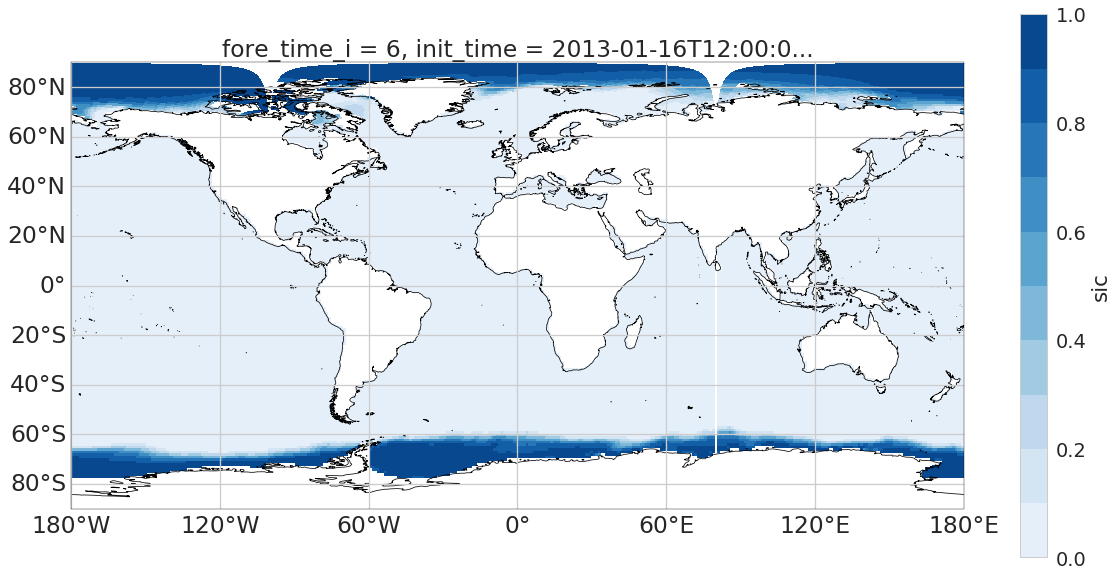

In [23]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
# ds_p = sic.mean(dim='init_time').mean(dim='fore_time').mean(dim='ensemble')
ds_p = sic.isel(init_time=0).isel(fore_time_i=6).mean(dim='ensemble')
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=0, vmax=1,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)));
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

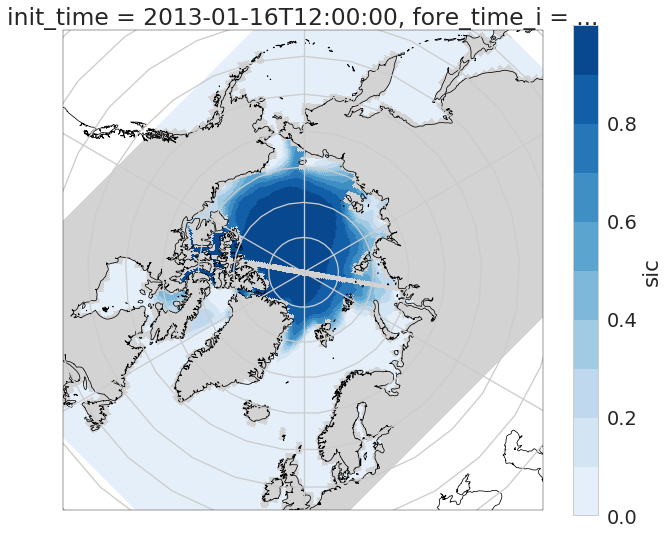

In [24]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
# ds_p2 = sic_out.mean(dim='init_time').mean(dim='fore_time').mean(dim='ensemble')
ds_p2 = sic_out.isel(init_time=0).isel(fore_time_i=6).mean(dim='ensemble')
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

In [26]:
# # Save regridded to netcdf file
f_out = os.path.join(data_out, 'GFDL_FLORB01_Stereo.nc')
sic_out.to_netcdf(f_out)

In [27]:
# Clean up
regridder.clean_weight_file()  # clean-up

Remove file bilinear_200x360_304x448_peri.nc
